Aim: reconstruct the model fitted to one (or all) of the time series, and draw

In [11]:
# Getting the cell objects with the time series and AR stuff
# Just doing this for the 2020-02-07 dataset for the time being

import numpy as np
import scipy as sp
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import pipeline.dataimport
import pipeline.periodogram
import pipeline.tsman
import pipeline.vis

working_directory = './data/arin/'

# Import information for flavin exposure experiment from files
Flavin_rawdata = pipeline.dataimport.import_timeseries( \
        working_directory+'Flavinexpostest3_ffcorr_small.csv')
Flavin_dcategory = pipeline.dataimport.import_categories( \
        working_directory+'Flavinexpostest3_ffcorr_small_OscillationEvals.txt')
Flavin_births = pipeline.dataimport.import_births( \
        working_directory+'Flavinexpostest3_ffcorr_small_births.csv')

# Arranges information into DatasetAttr objects
Flavin_data = pipeline.dataimport.CellAttr_from_datasets( \
        timeseries_df = Flavin_rawdata,
        categories_array = Flavin_dcategory,
        births_df = Flavin_births)
Flavin = pipeline.DatasetAttr(Flavin_data)

# Add just the labels so as not to break things
for ii, cell in enumerate(Flavin.cells):
    cell.flavin.reading = cell.y
    cell.flavin.category = Flavin_dcategory[ii]
    
def add_classicalAttr(cell, oversampling_factor = 1):
    """Computes classical periodogram and adds PdgramAttr attributes"""
    cell.flavin.classical.freqs, cell.flavin.classical.power = \
            pipeline.periodogram.classical(cell.time, cell.flavin.reading_processed,
                                oversampling_factor = oversampling_factor)

def add_autoregAttr(cell):
    """
    Computes autoregressive model-based periodogram and adds PdgramAttr
    attributes
    """
    cell.flavin.autoreg = pipeline.PdgramAttr()
    cell.flavin.autoreg.label = \
            'Autogressive Model-Based Periodogram (Jia & Grima, 2020)'
    cell.flavin.autoreg.power_label = 'Power'
    freq_npoints = 1000
    cell.flavin.autoreg.freqs, cell.flavin.autoreg.power = \
            pipeline.periodogram.autoreg(cell.time,
                                         cell.flavin.reading_processed,
                                         freq_npoints)
for cell in Flavin.cells:
    cell.flavin.reading_processed = \
        pipeline.tsman.stdfilter(cell.flavin.reading, Fs = 1/2.5)

pipeline.tsman.population_detrend(Flavin.cells, 'flavin.reading_processed')

for cell in Flavin.cells:
    # Fourier
    add_classicalAttr(cell, oversampling_factor = 1)
    # AR
    add_autoregAttr(cell)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'Autofluorescence of cell 0 over time'}, xlabel='Time (min)', ylabel='Autofluorescence (AU)'>)

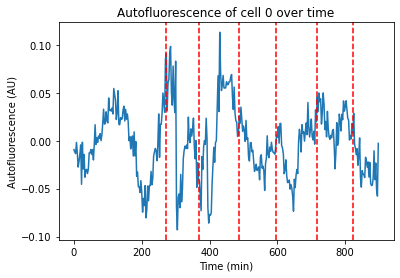

In [75]:
cell_index = 0
Flavin.cells[cell_index].plot_ts(y_attr='flavin.reading_processed')

In [76]:
timeseries = Flavin.cells[cell_index].flavin.reading_processed

from pipeline.ar_grima2020 import AR_Fit, AR_Power, optimise_ar_order

optimal_ar_order = optimise_ar_order(timeseries, int(3*np.sqrt(len(timeseries))))
print(f'Optimal AR order: {optimal_ar_order}')

model = AR_Fit(timeseries, optimal_ar_order)
print(f"Mean: {model.mean}")
print(f"Length of timeseries: {model.length}")
print(f"First element: {model.timeseries[0]}")
print(f"Autocorrelation function coefficients (R):\n {model.sample_acfs}")
print(f"Autoregression coefficients (phi):\n {model.ar_coeffs}")
print(f"Noise parameter: {model.noise_param}")

Optimal AR order: 7
Mean: -0.0012865841891323932
Length of timeseries: 360
First element: -0.009251009559771286
Autocorrelation function coefficients (R):
 [0.00125759 0.00105012 0.00097379 0.00092418 0.00081913 0.0007367
 0.00066381 0.00054801]
Autoregression coefficients (phi):
 [ 1.          0.59167699  0.18513635  0.20339428 -0.0381907  -0.00563318
  0.05441066 -0.13048869]
Noise parameter: 0.0003388252373914166


In [77]:
timeseries_modelled = np.empty(model.length)
for index in range(model.length):
    if index < optimal_ar_order:
        timeseries_modelled[index] = timeseries[index]
    else:
        preceding_points = timeseries[index-1:index-optimal_ar_order-1:-1] #check for OBOEs
        linear_combination = sum([phi*n
                                 for phi in model.ar_coeffs[1::]
                                 for n in preceding_points]) # matrix multiplication?
        timeseries_modelled[index] = (1/model.ar_coeffs[0])*(linear_combination - model.noise_param)

In [74]:
model.ar_coeffs[0]

1.0

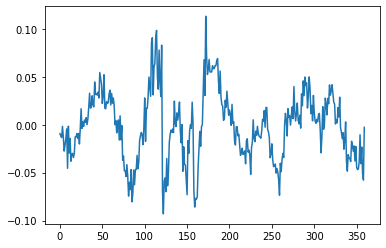

In [78]:
plt.plot(timeseries)

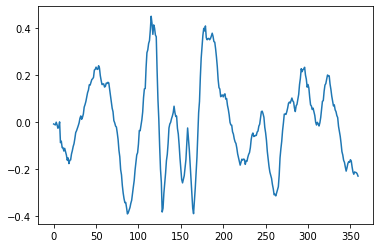

In [79]:
plt.plot(timeseries_modelled)

Comments
- Seems like the frequency sort of checks out
- But not the amplitude.  Though that can be scaled.  It's less important than the frequency.  What is the scaling factor?
- Do I have to take the first n time points, or can I grab something somewhere in the middle?  It will definitely produce a different output, but will the frequency change?
- What about time series that 'look worse'?